# Dutch Dataset: Calibration ver

In this notebook the optimal Deferral Net configuration is chosen, and the deferral tau threshold is calibrated.

Following the BRIDGET experimental pipeline, the Deferral Net is trained on the data predicted by the Human-in-Command process, then subsequently tested on the validation data to produce the optimal Tau deferral coefficient.

The architecture for the Nets to be tested are [(16, 8), (32, 16), (64, 32)].

The optimizer used is ADAM

The dropout rate was set to 0.2 to ensure the nets dont overfit initially, then tested up to 0.5



### Libraries and functions

In [1]:
# retrieving all libraries
%load_ext autoreload
%autoreload 2


from matplotlib import pyplot as plt

import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import metrics
from river import ensemble, linear_model, forest

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper


from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


26-Feb-09 20:22:02 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truths')
    plt.title('Confusion Matrix, DefNet')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Expert: Accurate, Trusting

In [4]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\dutch\calibration_datasets\acc_t_calibration")
df_val= df_val.rename(columns={'occupation': 'ground_truth'})  # per non confondermi


In [5]:
# retrieving data

df_acc_t = pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_accurate_trusting")

df_acc_t= df_acc_t.rename(columns={'occupation':'g_truth'})  

df_acc_t.to_csv(r".\processed_data\dutch\switch_ds\acc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [6]:
feat_order = [c for c in df_acc_t.columns if c not in [
    'occupation', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_acc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_t['g_truth'].values, dtype=torch.long)

acc_t_df = TensorDataset(X_cal, y_cal)
acc_t_loader = DataLoader(acc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1


#### Net 1: 16/8

tau= 0.74

In [7]:
## instantiating def net

small_net= DeferralNet(input_size=11, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.0008,
                       weight_decay= 5e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [8]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\acc_t_models',
    filename_prefix='16_8_acc_t',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_t_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.61
Training Results - Epoch[1] Avg accuracy: 0.70 Avg loss: 0.64
Validation Results - Epoch[1] Avg accuracy: 0.55 Avg loss: 0.71
End of Epoch 1: Learning Rate 0.0008
Epoch[2], Iter[200] Loss: 0.60
Training Results - Epoch[2] Avg accuracy: 0.75 Avg loss: 0.59
Validation Results - Epoch[2] Avg accuracy: 0.62 Avg loss: 0.67
End of Epoch 2: Learning Rate 0.0008
Epoch[3], Iter[300] Loss: 0.57
Training Results - Epoch[3] Avg accuracy: 0.81 Avg loss: 0.54
Validation Results - Epoch[3] Avg accuracy: 0.70 Avg loss: 0.64
End of Epoch 3: Learning Rate 0.0008
Epoch[4], Iter[400] Loss: 0.52
Training Results - Epoch[4] Avg accuracy: 0.84 Avg loss: 0.50
Validation Results - Epoch[4] Avg accuracy: 0.73 Avg loss: 0.63
End of Epoch 4: Learning Rate 0.0008
Epoch[5], Iter[500] Loss: 0.54
Training Results - Epoch[5] Avg accuracy: 0.84 Avg loss: 0.48
Validation Results - Epoch[5] Avg accuracy: 0.74 Avg loss: 0.63
End of Epoch 5: Learning Rate 0.0008
Epoch[6], Iter[600] Loss: 0.46

State:
	iteration: 3270
	epoch: 30
	epoch_length: 109
	max_epochs: 30
	output: 0.42988091707229614
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

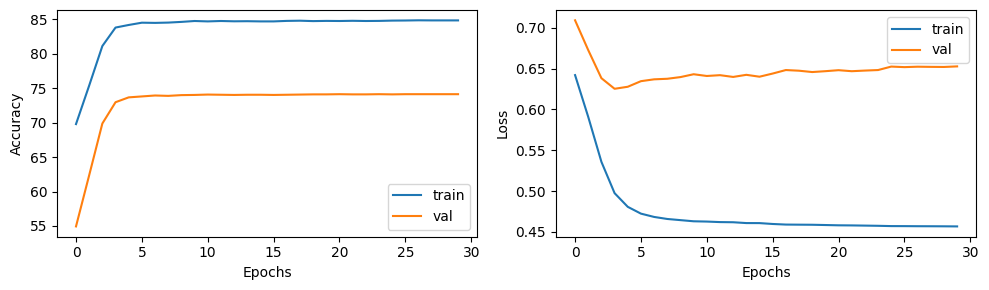

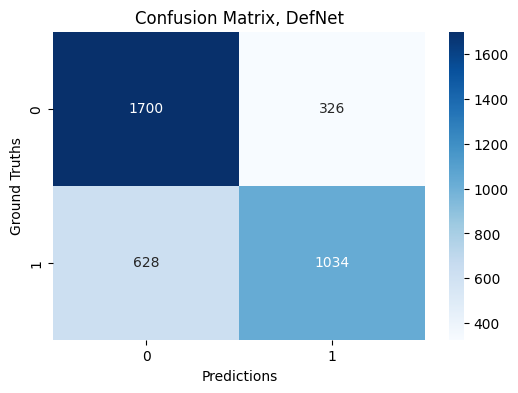

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2026
           1       0.76      0.62      0.68      1662

    accuracy                           0.74      3688
   macro avg       0.75      0.73      0.73      3688
weighted avg       0.74      0.74      0.74      3688



In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [10]:
model_path = r'.\nets\dutch\acc_t_models\16_8_acc_t_model_30.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.74
0.7925577416595381


#### Net 2: 32/16

tau= 0.75

In [11]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0008,
                       weight_decay= 5e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Epoch[1], Iter[100] Loss: 0.59
Training Results - Epoch[1] Avg accuracy: 0.74 Avg loss: 0.63
Validation Results - Epoch[1] Avg accuracy: 0.61 Avg loss: 0.68
End of Epoch 1: Learning Rate 0.0008
Epoch[2], Iter[200] Loss: 0.54
Training Results - Epoch[2] Avg accuracy: 0.82 Avg loss: 0.54
Validation Results - Epoch[2] Avg accuracy: 0.72 Avg loss: 0.61
End of Epoch 2: Learning Rate 0.0008
Epoch[3], Iter[300] Loss: 0.50
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.49
Validation Results - Epoch[3] Avg accuracy: 0.74 Avg loss: 0.59
End of Epoch 3: Learning Rate 0.0008
Epoch[4], Iter[400] Loss: 0.53
Training Results - Epoch[4] Avg accuracy: 0.85 Avg loss: 0.47
Validation Results - Epoch[4] Avg accuracy: 0.74 Avg loss: 0.61
End of Epoch 4: Learning Rate 0.0008
Epoch[5], Iter[500] Loss: 0.52
Training Results - Epoch[5] Avg accuracy: 0.85 Avg loss: 0.47
Validation Results - Epoch[5] Avg accuracy: 0.74 Avg loss: 0.62
End of Epoch 5: Learning Rate 0.0008
Epoch[6], Iter[600] Loss: 0.45

2026-02-09 20:23:09,417 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[25] Avg accuracy: 0.74 Avg loss: 0.65
End of Epoch 25: Learning Rate 0.0001


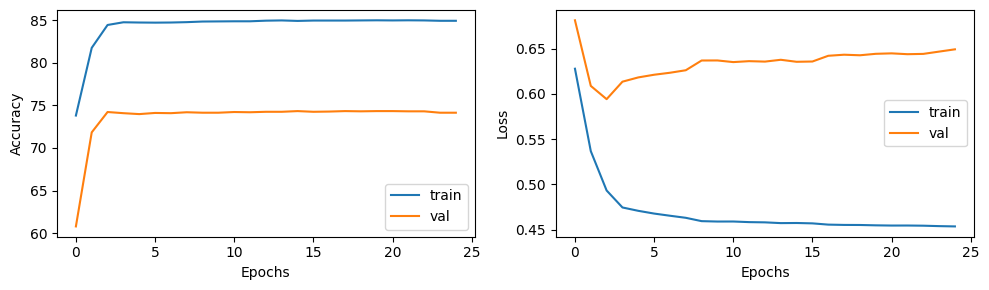

In [12]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'nets\dutch\acc_t_models',
    filename_prefix='32_16_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

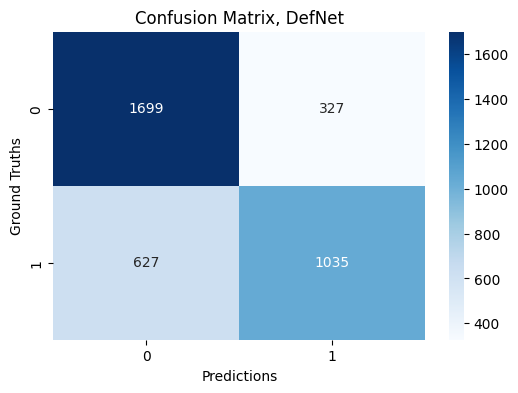

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2026
           1       0.76      0.62      0.68      1662

    accuracy                           0.74      3688
   macro avg       0.75      0.73      0.73      3688
weighted avg       0.74      0.74      0.74      3688



In [13]:
plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [14]:
# dopo avere scelto la net migliore

model_path = r'nets\dutch\acc_t_models\32_16_acc_t_model_25.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.75
0.7968144640551011


#### Net 3: 64/32

tau= 0.77

In [15]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

net_3= DeferralNet(input_size= 11, hidden_layer1= 64, hidden_layer2= 32, output_size=2, dropout_coeff=0.05)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_3.to(device)

optimizer = optim.Adam(params=net_3.parameters(), 
                       lr=0.0008,
                       weight_decay= 5e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Epoch[1], Iter[100] Loss: 0.54
Training Results - Epoch[1] Avg accuracy: 0.82 Avg loss: 0.56
Validation Results - Epoch[1] Avg accuracy: 0.71 Avg loss: 0.62
End of Epoch 1: Learning Rate 0.0008
Epoch[2], Iter[200] Loss: 0.48
Training Results - Epoch[2] Avg accuracy: 0.85 Avg loss: 0.48
Validation Results - Epoch[2] Avg accuracy: 0.74 Avg loss: 0.60
End of Epoch 2: Learning Rate 0.0008
Epoch[3], Iter[300] Loss: 0.48
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.47
Validation Results - Epoch[3] Avg accuracy: 0.74 Avg loss: 0.61
End of Epoch 3: Learning Rate 0.0008
Epoch[4], Iter[400] Loss: 0.57
Training Results - Epoch[4] Avg accuracy: 0.85 Avg loss: 0.47
Validation Results - Epoch[4] Avg accuracy: 0.74 Avg loss: 0.61
End of Epoch 4: Learning Rate 0.0008
Epoch[5], Iter[500] Loss: 0.49
Training Results - Epoch[5] Avg accuracy: 0.85 Avg loss: 0.47
Validation Results - Epoch[5] Avg accuracy: 0.74 Avg loss: 0.61
End of Epoch 5: Learning Rate 0.0008
Epoch[6], Iter[600] Loss: 0.44

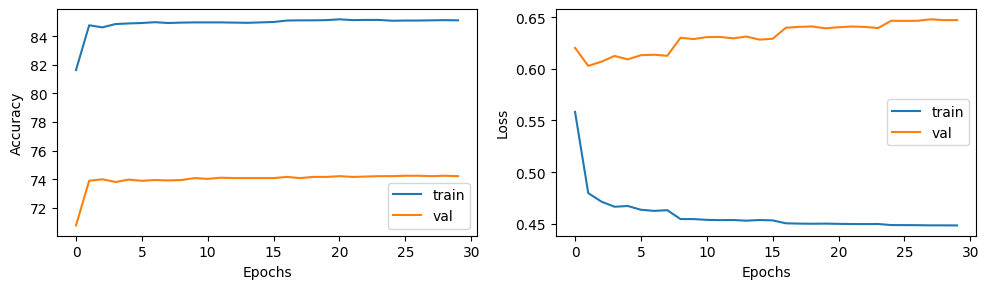

In [16]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(net_3, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(net_3, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(net_3, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")
    
# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'nets\dutch\acc_t_models',
    filename_prefix='64_32_acc_t',
    n_saved=1,
    create_dir=True,
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
    require_empty= False
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': net_3})


trainer.run(acc_t_loader, max_epochs= 30 )



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

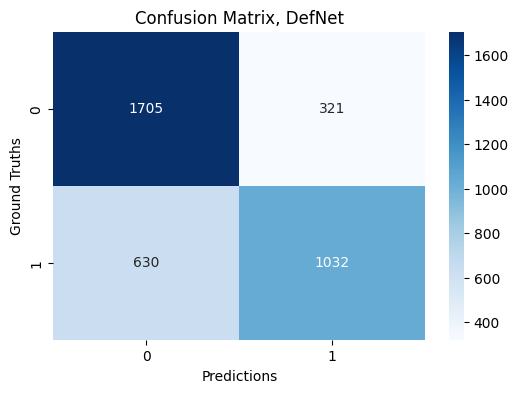

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2026
           1       0.76      0.62      0.68      1662

    accuracy                           0.74      3688
   macro avg       0.75      0.73      0.73      3688
weighted avg       0.74      0.74      0.74      3688



In [17]:
plot_confusion_matrix(net_3, val_loader, device)

##### Tau Threshold

In [18]:
# dopo avere scelto la net migliore
model_path = r'nets\dutch\acc_t_models\64_32_acc_t_model_30.pt' 
net_3.load_state_dict(torch.load(model_path))
net_3.eval()

with torch.no_grad():
   probas= net_3.predict_proba_nn(X_val, device)
   y_pred= net_3.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.77
0.8012394864984507


### Deferral Strat 2 (anqi mao style) con la rete 2

either of these 

  0.214286       0.856381       0.109156

  0.230612       0.851622       0.044989

  0.246939       0.849892       0.017592

In [19]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)

In [20]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [21]:
save_dir = r'.\r_nets\dutch'
os.makedirs(save_dir, exist_ok=True)

r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

Epoch 1/20 - Loss: 0.6280
Epoch 2/20 - Loss: 0.6047
Epoch 3/20 - Loss: 0.5835
Epoch 4/20 - Loss: 0.5625
Epoch 5/20 - Loss: 0.5400
Epoch 6/20 - Loss: 0.5174
Epoch 7/20 - Loss: 0.4951
Epoch 8/20 - Loss: 0.4734
Epoch 9/20 - Loss: 0.4494
Epoch 10/20 - Loss: 0.4319
Epoch 11/20 - Loss: 0.4170
Epoch 12/20 - Loss: 0.4050
Epoch 13/20 - Loss: 0.3978
Epoch 14/20 - Loss: 0.3932
Epoch 15/20 - Loss: 0.3889
Epoch 16/20 - Loss: 0.3893
Epoch 17/20 - Loss: 0.3867
Epoch 18/20 - Loss: 0.3853
Epoch 19/20 - Loss: 0.3844
Epoch 20/20 - Loss: 0.3849
✅ r_net salvata correttamente in .\r_nets\dutch


In [22]:
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

#richiamo la net 
large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.2)

net_path= r".\nets\dutch\acc_t_models\32_16_acc_t_model_25.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.9, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       0.998846       0.992358
1   0.116327       0.993655       0.962797
2   0.132653       0.974910       0.878154
3   0.148980       0.945205       0.724153
4   0.165306       0.908580       0.536265
5   0.181633       0.882336       0.349964
6   0.197959       0.864744       0.209517
7   0.214286       0.856381       0.109156
8   0.230612       0.851622       0.044989
9   0.246939       0.849892       0.017592
10  0.263265       0.849171       0.005335
11  0.279592       0.849171       0.001154
12  0.295918       0.849171       0.000144
13  0.312245       0.849171       0.000144
14  0.328571       0.849171       0.000000
15  0.344898       0.849171       0.000000
16  0.361224       0.849171       0.000000
17  0.377551       0.849171       0.000000
18  0.393878       0.849171       0.000000
19  0.410204       0.849171       0.000000
20  0.426531       0.849171       0.000000
21  0.442857       0.849171       0.000000
22  0.45918

## Expert: Inaccurate, Trusting

In [40]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\dutch\calibration_datasets\inacc_t_calibration")
df_val= df_val.rename(columns={'occupation': 'ground_truth'})  # per non confondermi


In [41]:
# dropping irrelevant feat + renaming the decision column as 'ground truth' 
df_inacc_t= pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_inaccurate_trusting")

df_inacc_t= df_inacc_t.rename(columns={'occupation':'g_truth'})  

df_inacc_t.to_csv(r".\processed_data\dutch\switch_ds\inacc_t_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [42]:
feat_order = [c for c in df_inacc_t.columns if c not in [
    'occupation', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_inacc_t[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_t['g_truth'].values, dtype=torch.long)

inacc_t_df = TensorDataset(X_cal, y_cal)
inacc_t_loader = DataLoader(inacc_t_df, batch_size=64, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=64, shuffle=False)

### Strat 1

tau= 0.75

#### Net 1

In [43]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

small_net= DeferralNet(input_size=11, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.001,
                       weight_decay= 5e-3
                    )

criterion= nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Training

In [44]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\inacc_t_models',
    filename_prefix='16_8',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_t_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.68
Training Results - Epoch[1] Avg accuracy: 0.62 Avg loss: 0.64
Validation Results - Epoch[1] Avg accuracy: 0.55 Avg loss: 0.67
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[200] Loss: 0.56
Training Results - Epoch[2] Avg accuracy: 0.81 Avg loss: 0.54
Validation Results - Epoch[2] Avg accuracy: 0.72 Avg loss: 0.59
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[300] Loss: 0.51
Training Results - Epoch[3] Avg accuracy: 0.79 Avg loss: 0.48
Validation Results - Epoch[3] Avg accuracy: 0.70 Avg loss: 0.59
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[400] Loss: 0.41
Training Results - Epoch[4] Avg accuracy: 0.80 Avg loss: 0.46
Validation Results - Epoch[4] Avg accuracy: 0.69 Avg loss: 0.60
End of Epoch 4: Learning Rate 0.001
Epoch[5], Iter[500] Loss: 0.49
Training Results - Epoch[5] Avg accuracy: 0.80 Avg loss: 0.45
Validation Results - Epoch[5] Avg accuracy: 0.70 Avg loss: 0.60
End of Epoch 5: Learning Rate 0.001
Epoch[6], Iter[600] Loss: 0.35
Trai

2026-02-09 20:29:17,872 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[17] Avg accuracy: 0.83 Avg loss: 0.41
Validation Results - Epoch[17] Avg accuracy: 0.71 Avg loss: 0.62
End of Epoch 17: Learning Rate 0.00025


State:
	iteration: 1853
	epoch: 17
	epoch_length: 109
	max_epochs: 30
	output: 0.607792317867279
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

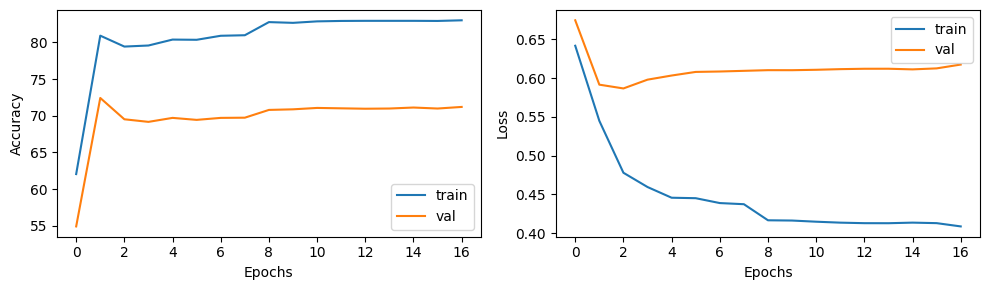

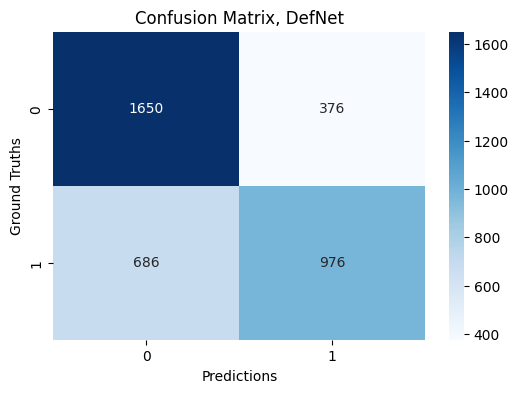

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      2026
           1       0.72      0.59      0.65      1662

    accuracy                           0.71      3688
   macro avg       0.71      0.70      0.70      3688
weighted avg       0.71      0.71      0.71      3688



In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [46]:
# dopo avere scelto la net migliore

model_path = r'nets\dutch\inacc_t_models\16_8_model_17.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.78
0.7680776014109347


#### Net 2: 32/16

In [48]:
## instantiating the Deferral Net structures + Dropout rate 0.2 e Early Stopping

large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.0008,
                       weight_decay= 5e-3
                    )

weights = torch.tensor([1.0, 1.3]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Epoch[1], Iter[100] Loss: 0.69
Training Results - Epoch[1] Avg accuracy: 0.74 Avg loss: 0.67
Validation Results - Epoch[1] Avg accuracy: 0.70 Avg loss: 0.67
End of Epoch 1: Learning Rate 0.0008
Epoch[2], Iter[200] Loss: 0.59
Training Results - Epoch[2] Avg accuracy: 0.71 Avg loss: 0.57
Validation Results - Epoch[2] Avg accuracy: 0.68 Avg loss: 0.61
End of Epoch 2: Learning Rate 0.0008
Epoch[3], Iter[300] Loss: 0.56
Training Results - Epoch[3] Avg accuracy: 0.76 Avg loss: 0.53
Validation Results - Epoch[3] Avg accuracy: 0.68 Avg loss: 0.62
End of Epoch 3: Learning Rate 0.0008
Epoch[4], Iter[400] Loss: 0.47
Training Results - Epoch[4] Avg accuracy: 0.78 Avg loss: 0.52
Validation Results - Epoch[4] Avg accuracy: 0.68 Avg loss: 0.62
End of Epoch 4: Learning Rate 0.0008
Epoch[5], Iter[500] Loss: 0.52
Training Results - Epoch[5] Avg accuracy: 0.78 Avg loss: 0.51
Validation Results - Epoch[5] Avg accuracy: 0.68 Avg loss: 0.63
End of Epoch 5: Learning Rate 0.0008
Epoch[6], Iter[600] Loss: 0.46

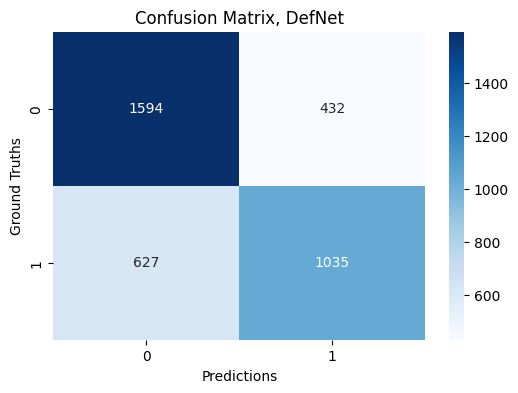

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2026
           1       0.71      0.62      0.66      1662

    accuracy                           0.71      3688
   macro avg       0.71      0.70      0.71      3688
weighted avg       0.71      0.71      0.71      3688



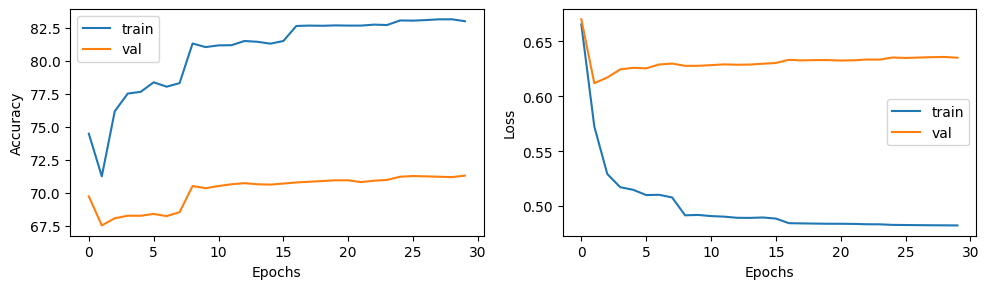

In [49]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_t_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\inacc_t_models',
    filename_prefix='32_16',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_t_loader, max_epochs= 30)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [50]:
# dopo avere scelto la net migliore
model_path = r'nets\dutch\inacc_t_models\32_16_model_30.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.75
0.7730220492866408


### Deferral Strat 2 (anqi mao style)

i papabili

tau r            acc           def rate

0.165306       0.843547       0.057967

In [51]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_t.iterrows():

    x_i = row[feat_order].values.tolist()
    #x_i = list(entry['dict_form'].values())
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [52]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")

torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_t.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.3946
Epoch 2/20 - Loss: 0.3477
Epoch 3/20 - Loss: 0.3458
Epoch 4/20 - Loss: 0.3420
Epoch 5/20 - Loss: 0.3414
Epoch 6/20 - Loss: 0.3394
Epoch 7/20 - Loss: 0.3396
Epoch 8/20 - Loss: 0.3396
Epoch 9/20 - Loss: 0.3386
Epoch 10/20 - Loss: 0.3378
Epoch 11/20 - Loss: 0.3377
Epoch 12/20 - Loss: 0.3376
Epoch 13/20 - Loss: 0.3366
Epoch 14/20 - Loss: 0.3364
Epoch 15/20 - Loss: 0.3365
Epoch 16/20 - Loss: 0.3365
Epoch 17/20 - Loss: 0.3362
Epoch 18/20 - Loss: 0.3356
Epoch 19/20 - Loss: 0.3356
Epoch 20/20 - Loss: 0.3360
✅ r_net salvata correttamente in .\r_nets\dutch


In [54]:
#richiamo la net 
large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.1)

net_path= r".\nets\dutch\inacc_t_models\32_16_model_30.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.9, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.018367       1.000000       1.000000
2   0.036735       1.000000       1.000000
3   0.055102       1.000000       1.000000
4   0.073469       1.000000       1.000000
5   0.091837       0.998991       0.995674
6   0.110204       0.994232       0.964239
7   0.128571       0.970296       0.787888
8   0.146939       0.911464       0.437203
9   0.165306       0.843547       0.057967
10  0.183673       0.829849       0.000000
11  0.202041       0.829849       0.000000
12  0.220408       0.829849       0.000000
13  0.238776       0.829849       0.000000
14  0.257143       0.829849       0.000000
15  0.275510       0.829849       0.000000
16  0.293878       0.829849       0.000000
17  0.312245       0.829849       0.000000
18  0.330612       0.829849       0.000000
19  0.348980       0.829849       0.000000
20  0.367347       0.829849       0.000000
21  0.385714       0.829849       0.000000
22  0.40408

## Expert: Accurate, Not Trusting

In [55]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\dutch\calibration_datasets\acc_nt_calibration")
df_val= df_val.rename(columns={'occupation': 'ground_truth'})  # per non confondermi

In [56]:
# retrieving data

df_acc_nt = pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_accurate_not_trusting")


df_acc_nt= df_acc_nt.rename(columns={'occupation':'g_truth'})  

df_acc_nt.to_csv(r".\processed_data\dutch\switch_ds\acc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch



In [57]:
feat_order = [c for c in df_acc_nt.columns if c not in [
    'occupation', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

X_cal = torch.tensor(df_acc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_acc_nt['g_truth'].values, dtype=torch.long)

acc_nt_df = TensorDataset(X_cal, y_cal)
acc_nt_loader = DataLoader(acc_nt_df, batch_size=32, shuffle=False)

X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Confidence Based Deferral

#### Net 1 16/8

In [58]:
small_net= DeferralNet(input_size=11, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.001,
                       weight_decay= 5e-3
                    )


weights = torch.tensor([1.0, 1.5]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [59]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\acc_nt_models',
    filename_prefix='16_8_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty= False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(acc_nt_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.71
Epoch[1], Iter[200] Loss: 0.54
Training Results - Epoch[1] Avg accuracy: 0.79 Avg loss: 0.57
Validation Results - Epoch[1] Avg accuracy: 0.67 Avg loss: 0.66
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[300] Loss: 0.51
Epoch[2], Iter[400] Loss: 0.53
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.42
Validation Results - Epoch[2] Avg accuracy: 0.73 Avg loss: 0.60
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[500] Loss: 0.53
Epoch[3], Iter[600] Loss: 0.48
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.38
Validation Results - Epoch[3] Avg accuracy: 0.74 Avg loss: 0.64
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[700] Loss: 0.38
Epoch[4], Iter[800] Loss: 0.24
Training Results - Epoch[4] Avg accuracy: 0.85 Avg loss: 0.37
Validation Results - Epoch[4] Avg accuracy: 0.74 Avg loss: 0.67
End of Epoch 4: Learning Rate 0.001
Epoch[5], Iter[900] Loss: 0.48
Epoch[5], Iter[1000] Loss: 0.40
Training Results - Epoch[5] Avg accuracy:

2026-02-09 20:31:54,131 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[28] Avg accuracy: 0.85 Avg loss: 0.35
Validation Results - Epoch[28] Avg accuracy: 0.74 Avg loss: 0.72
End of Epoch 28: Learning Rate 0.000125


State:
	iteration: 6076
	epoch: 28
	epoch_length: 217
	max_epochs: 30
	output: 0.3371705710887909
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

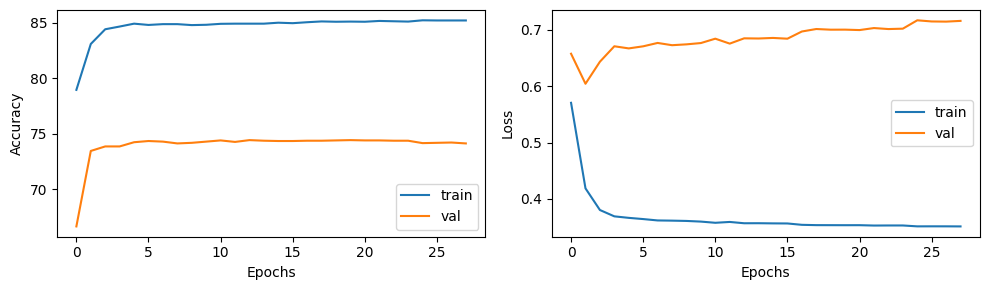

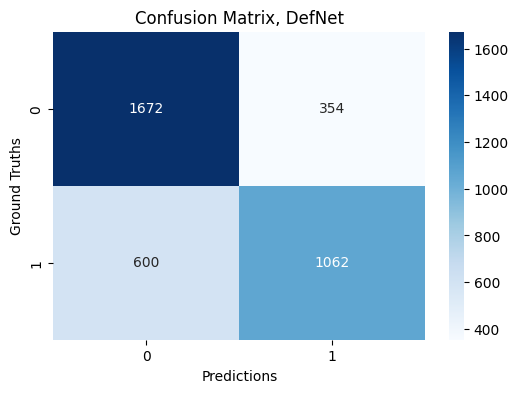

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      2026
           1       0.75      0.64      0.69      1662

    accuracy                           0.74      3688
   macro avg       0.74      0.73      0.73      3688
weighted avg       0.74      0.74      0.74      3688



In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [61]:
# dopo avere scelto la net migliore
model_path = r'nets\dutch\acc_nt_models\16_8_acc_nt_model_28.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.81
0.7967698519515478


#### Net 2 32/16

In [62]:
large_net= DeferralNet(input_size=11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)


optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.001,
                       weight_decay= 5e-3
                    )
weights = torch.tensor([1.0, 1.2]).to(device)
criterion= nn.CrossEntropyLoss(weight=weights)


scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
large_net.to(device)

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Training

Epoch[1], Iter[100] Loss: 0.68
Epoch[1], Iter[200] Loss: 0.48
Training Results - Epoch[1] Avg accuracy: 0.82 Avg loss: 0.46
Validation Results - Epoch[1] Avg accuracy: 0.70 Avg loss: 0.59
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[300] Loss: 0.37
Epoch[2], Iter[400] Loss: 0.42
Training Results - Epoch[2] Avg accuracy: 0.85 Avg loss: 0.37
Validation Results - Epoch[2] Avg accuracy: 0.74 Avg loss: 0.61
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[500] Loss: 0.48
Epoch[3], Iter[600] Loss: 0.46
Training Results - Epoch[3] Avg accuracy: 0.85 Avg loss: 0.36
Validation Results - Epoch[3] Avg accuracy: 0.73 Avg loss: 0.64
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[700] Loss: 0.32
Epoch[4], Iter[800] Loss: 0.23
Training Results - Epoch[4] Avg accuracy: 0.85 Avg loss: 0.35
Validation Results - Epoch[4] Avg accuracy: 0.74 Avg loss: 0.65
End of Epoch 4: Learning Rate 0.001
Epoch[5], Iter[900] Loss: 0.41
Epoch[5], Iter[1000] Loss: 0.44
Training Results - Epoch[5] Avg accuracy:

2026-02-09 20:32:33,430 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Training Results - Epoch[19] Avg accuracy: 0.85 Avg loss: 0.34
Validation Results - Epoch[19] Avg accuracy: 0.74 Avg loss: 0.68
End of Epoch 19: Learning Rate 0.00025


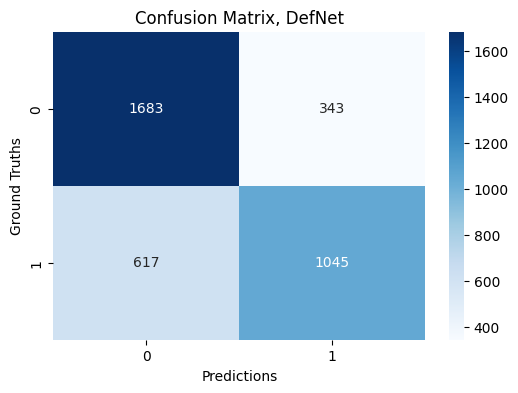

              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2026
           1       0.75      0.63      0.69      1662

    accuracy                           0.74      3688
   macro avg       0.74      0.73      0.73      3688
weighted avg       0.74      0.74      0.74      3688



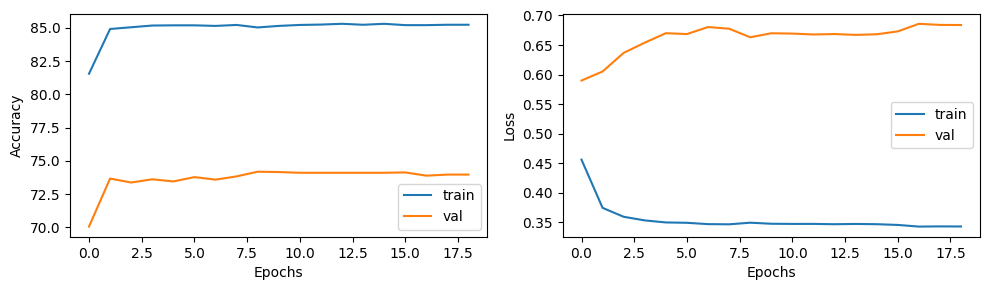

In [63]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(acc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\acc_nt_models',
    filename_prefix='32_16_acc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(acc_nt_loader, max_epochs= 30)

plot_confusion_matrix(large_net, val_loader, device)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

##### Tau Threshold

In [64]:
# dopo avere scelto la net migliore

model_path = r'nets\dutch\acc_nt_models\32_16_acc_nt_model_19.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.8
0.7931646693297825


### Anqi Mao style Deferral

papabili

13  0.206122       0.856957       0.075703

14  0.214286       0.854506       0.050757

15  0.222449       0.853641       0.034607

In [65]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_acc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)


In [66]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-4)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) 
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_acc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)

p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()

Epoch 1/20 - Loss: 0.6870
Epoch 2/20 - Loss: 0.6530
Epoch 3/20 - Loss: 0.5935
Epoch 4/20 - Loss: 0.5127
Epoch 5/20 - Loss: 0.4286
Epoch 6/20 - Loss: 0.3881
Epoch 7/20 - Loss: 0.3756
Epoch 8/20 - Loss: 0.3718
Epoch 9/20 - Loss: 0.3693
Epoch 10/20 - Loss: 0.3691
Epoch 11/20 - Loss: 0.3678
Epoch 12/20 - Loss: 0.3690
Epoch 13/20 - Loss: 0.3653
Epoch 14/20 - Loss: 0.3656
Epoch 15/20 - Loss: 0.3644
Epoch 16/20 - Loss: 0.3648
Epoch 17/20 - Loss: 0.3614
Epoch 18/20 - Loss: 0.3617
Epoch 19/20 - Loss: 0.3634
Epoch 20/20 - Loss: 0.3615
✅ r_net salvata correttamente in .\r_nets\dutch


In [67]:
#richiamo la net 
large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)

net_path= r"nets\dutch\acc_nt_models\32_16_acc_nt_model_19.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.1, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.100000       0.986734       0.927181
1   0.108163       0.978803       0.877722
2   0.116327       0.969142       0.818457
3   0.124490       0.956597       0.750397
4   0.132653       0.944196       0.669070
5   0.140816       0.927325       0.576352
6   0.148980       0.909301       0.494737
7   0.157143       0.895746       0.408652
8   0.165306       0.882048       0.325018
9   0.173469       0.874261       0.256236
10  0.181633       0.869070       0.197260
11  0.189796       0.863735       0.145926
12  0.197959       0.859841       0.111031
13  0.206122       0.856957       0.075703
14  0.214286       0.854506       0.050757
15  0.222449       0.853641       0.034607
16  0.230612       0.853064       0.021629
17  0.238776       0.852776       0.013843
18  0.246939       0.852343       0.008652
19  0.255102       0.852199       0.005047
20  0.263265       0.852199       0.002884
21  0.271429       0.852199       0.001154
22  0.27959

## Expert: Inaccurate, Not Trusting

In [68]:
# retrieving the calibration split 

df_val= pd.read_csv(r".\processed_data\dutch\calibration_datasets\inacc_nt_calibration")
df_val= df_val.rename(columns={'occupation': 'ground_truth'})  # per non confondermi

In [69]:
# retrieving data

df_inacc_nt = pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_inaccurate_not_trusting")
df_inacc_nt.head(n=5)

df_inacc_nt= df_inacc_nt.rename(columns={'occupation':'g_truth'})  

df_inacc_nt.to_csv(r".\processed_data\dutch\switch_ds\inacc_nt_switch", index= False) # questa versione di df è quella che viene passata a start Mic come df switch


In [70]:
feat_order = [c for c in df_inacc_nt.columns if c not in [
    'occupation', 'g_truth', 'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]


X_cal = torch.tensor(df_inacc_nt[feat_order].values, dtype=torch.float32)
y_cal = torch.tensor(df_inacc_nt['g_truth'].values, dtype=torch.long)

inacc_nt_df = TensorDataset(X_cal, y_cal)
inacc_nt_loader = DataLoader(inacc_nt_df, batch_size=64, shuffle=False)


X_val = torch.tensor(df_val[feat_order].values, dtype=torch.float32)
y_val = torch.tensor(df_val['ground_truth'].values, dtype=torch.long)

val_d = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_d, batch_size=32, shuffle=False)

### Deferral Strat 1

#### Net 1

In [71]:
small_net= DeferralNet(input_size=11, hidden_layer1= 16, hidden_layer2= 8, output_size=2, dropout_coeff=0.05)

small_net.to(device)

optimizer = optim.Adam(params=small_net.parameters(), 
                       lr=0.001,
                       weight_decay= 5e-3
                    )

weights = torch.tensor([1.0, 1.5]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

In [72]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(small_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(small_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")

# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\inacc_nt_models',
    filename_prefix='16_8_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': small_net})


trainer.run(inacc_nt_loader, max_epochs= 30)

Epoch[1], Iter[100] Loss: 0.68
Training Results - Epoch[1] Avg accuracy: 0.73 Avg loss: 0.65
Validation Results - Epoch[1] Avg accuracy: 0.66 Avg loss: 0.67
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[200] Loss: 0.61
Training Results - Epoch[2] Avg accuracy: 0.60 Avg loss: 0.62
Validation Results - Epoch[2] Avg accuracy: 0.61 Avg loss: 0.63
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[300] Loss: 0.66
Training Results - Epoch[3] Avg accuracy: 0.61 Avg loss: 0.60
Validation Results - Epoch[3] Avg accuracy: 0.62 Avg loss: 0.61
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[400] Loss: 0.50
Training Results - Epoch[4] Avg accuracy: 0.63 Avg loss: 0.59
Validation Results - Epoch[4] Avg accuracy: 0.63 Avg loss: 0.61
End of Epoch 4: Learning Rate 0.001
Epoch[5], Iter[500] Loss: 0.54
Training Results - Epoch[5] Avg accuracy: 0.64 Avg loss: 0.58
Validation Results - Epoch[5] Avg accuracy: 0.64 Avg loss: 0.60
End of Epoch 5: Learning Rate 0.001
Epoch[6], Iter[600] Loss: 0.41
Trai

State:
	iteration: 3270
	epoch: 30
	epoch_length: 109
	max_epochs: 30
	output: 0.7321251034736633
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

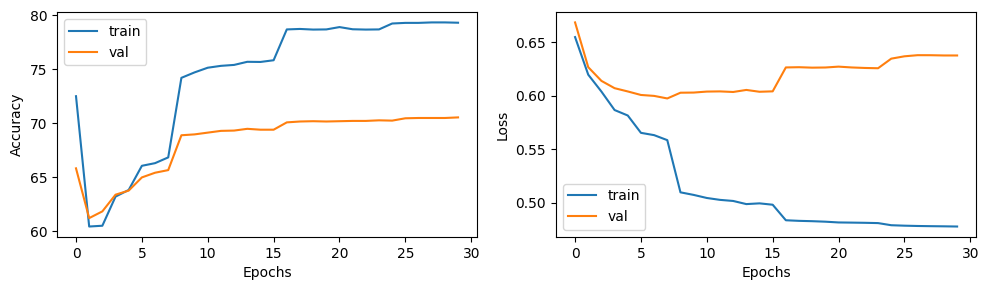

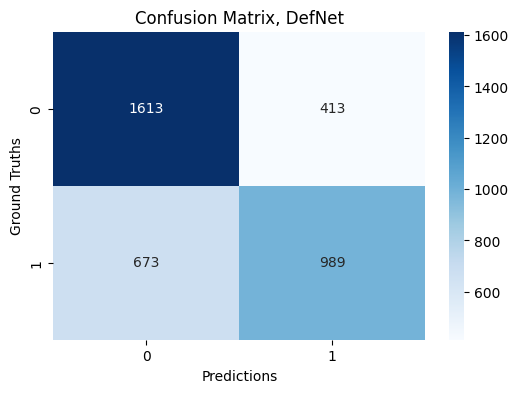

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      2026
           1       0.71      0.60      0.65      1662

    accuracy                           0.71      3688
   macro avg       0.71      0.70      0.70      3688
weighted avg       0.71      0.71      0.70      3688



In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(small_net, val_loader, device)

##### Tau Threshold

In [74]:
# dopo avere scelto la net migliore

model_path = r'nets\dutch\inacc_nt_models\16_8_inacc_nt_model_30.pt' 
small_net.load_state_dict(torch.load(model_path))
small_net.eval()

with torch.no_grad():
   probas= small_net.predict_proba_nn(X_val, device)
   y_pred= small_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)


0.73
0.7770758122743683


#### Net 2

In [75]:
large_net= DeferralNet(input_size=11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)

large_net.to(device)

optimizer = optim.Adam(params=large_net.parameters(), 
                       lr=0.001,
                       weight_decay= 5e-3
                    )


weights = torch.tensor([1.0, 1.5]).to(device)

criterion= nn.CrossEntropyLoss(weight=weights)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)


##### Training

Epoch[1], Iter[100] Loss: 0.68
Training Results - Epoch[1] Avg accuracy: 0.63 Avg loss: 0.67
Validation Results - Epoch[1] Avg accuracy: 0.63 Avg loss: 0.66
End of Epoch 1: Learning Rate 0.001
Epoch[2], Iter[200] Loss: 0.59
Training Results - Epoch[2] Avg accuracy: 0.54 Avg loss: 0.65
Validation Results - Epoch[2] Avg accuracy: 0.58 Avg loss: 0.62
End of Epoch 2: Learning Rate 0.001
Epoch[3], Iter[300] Loss: 0.64
Training Results - Epoch[3] Avg accuracy: 0.59 Avg loss: 0.62
Validation Results - Epoch[3] Avg accuracy: 0.61 Avg loss: 0.61
End of Epoch 3: Learning Rate 0.001
Epoch[4], Iter[400] Loss: 0.49
Training Results - Epoch[4] Avg accuracy: 0.61 Avg loss: 0.61
Validation Results - Epoch[4] Avg accuracy: 0.62 Avg loss: 0.61
End of Epoch 4: Learning Rate 0.001
Epoch[5], Iter[500] Loss: 0.54
Training Results - Epoch[5] Avg accuracy: 0.61 Avg loss: 0.61
Validation Results - Epoch[5] Avg accuracy: 0.62 Avg loss: 0.61
End of Epoch 5: Learning Rate 0.001
Epoch[6], Iter[600] Loss: 0.39
Trai

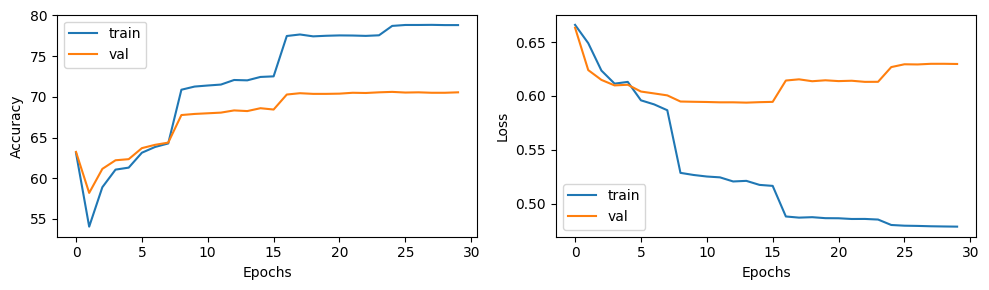

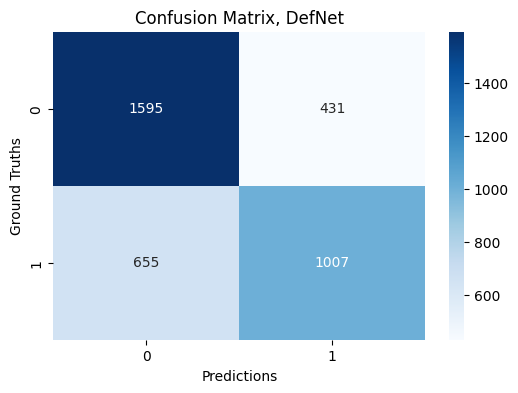

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2026
           1       0.70      0.61      0.65      1662

    accuracy                           0.71      3688
   macro avg       0.70      0.70      0.70      3688
weighted avg       0.71      0.71      0.70      3688



In [76]:
# Setting Ignite environment (preso direttamente da lab nn pytorch)

# ignite trainer
trainer = create_supervised_trainer(large_net, optimizer, criterion, device)

# validation e accuracy metrics are ignite metrics
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
val_metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

# ignite train and validation evaluators
train_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(large_net, metrics=val_metrics, device=device)

# For logging purposes we add a function to be executed at the end of every log_interval-th iteration:
log_interval = 100

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# after a training epoch, computes training and validation metrics (train_eval on train_loader and val_eval on val_loader)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(inacc_nt_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics['accuracy']*100)
    training_history['loss'].append(metrics['loss'])
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    validation_history['accuracy'].append(metrics['accuracy']*100)
    validation_history['loss'].append(metrics['loss'])
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(trainer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print(f"End of Epoch {trainer.state.epoch}: Learning Rate {lr}")


# return current value of any metric defined in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]


# define early stopping and model checkpoint
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

checkpoint = ModelCheckpoint(
    dirname=r'.\nets\dutch\inacc_nt_models',
    filename_prefix='32_16_inacc_nt',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    global_step_transform=global_step_from_engine(trainer) # helps fetch the trainer's state
)

# Attach early stopping and model checkpoint to the trainer
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)
val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint, {'model': large_net})


trainer.run(inacc_nt_loader, max_epochs= 30)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(training_history['accuracy'], label='train')
axes[0].plot(validation_history['accuracy'], label='val')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(training_history['loss'], label='train')
axes[1].plot(validation_history['loss'], label='val')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
fig.tight_layout()

plt.show()

plot_confusion_matrix(large_net, val_loader, device)

##### Tau Threshold

In [77]:
# dopo avere scelto la net migliore
model_path = r'nets\dutch\inacc_nt_models\32_16_inacc_nt_model_30.pt' 
large_net.load_state_dict(torch.load(model_path))
large_net.eval()

with torch.no_grad():
   probas= large_net.predict_proba_nn(X_val, device)
   y_pred= large_net.predict(X_val,device)

max_conf= probas.max(axis=1)

taus= np.linspace(0.50, 0.99, 50)
y_val_np= y_val.cpu().numpy() if torch.is_tensor(y_val) else np.array(y_val)

res= [evaluate_threshold(t, max_conf, y_pred, y_val_np) for t in taus]

best_tau = None
best_acc = -1
for tau, (acc_sel, cov, _) in zip(taus, res):
   if cov >= 0.6 and acc_sel > best_acc:
      best_acc = acc_sel 
      best_tau = tau


print(best_tau)
print(best_acc)



0.73
0.7757629367536488


### Anqi Mao Strat


papabili

 0.173469       0.814564       0.098630

In [78]:
def_data = []
pred_correct = []
C = []
alpha = 1.0  
beta = 0.1


for idx, row in df_inacc_nt.iterrows():

    x_i = row[feat_order].values.tolist()
    
    
    # 1 se la macchina ha indovinato, 0 se ha sbagliato
    corr = 1.0 if row['machine prediction'] == row['ground truth'] else 0.0 # la ground truth originale
    
    # Costo di deferral C
    if row['provider'] == "H":
        c_i = beta # L'umano è stato scelto ed era utile
    else:
        c_i = alpha + beta # L'umano non è stato scelto, chiamarlo sarebbe un costo extra
    
    def_data.append(x_i)
    pred_correct.append(corr)
    C.append(c_i)

X_def = torch.tensor(def_data, dtype=torch.float32)
pred_correct = torch.tensor(pred_correct, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)



In [79]:
# sulla base di x_def chiamo la rete 

r_net= DeferralNet(input_size=X_def.shape[1], hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff= 0.2)


optimizer = torch.optim.Adam(r_net.parameters(), lr=1e-3)
dataset = torch.utils.data.TensorDataset(X_def, pred_correct, C)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
r_net.to(device)
r_net.train()

for epoch in range(20):
    running_loss = 0.0
    for xb, pc_b, c_b in loader:
      
        xb, pc_b, c_b = xb.to(device), pc_b.to(device), c_b.to(device)
        
        r_vals = r_net(xb).view(-1) # .view(-1) assicura che r sia un vettore piatto
    
        loss = deferral_loss(r_vals, pc_b, c_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    print(f"Epoch {epoch+1}/20 - Loss: {running_loss/len(loader):.4f}")
    
torch.save(r_net.state_dict(), os.path.join(save_dir, 'r_net_inacc_nt.pth'))
print("✅ r_net salvata correttamente in", save_dir)
p_defer_calib = p_defer(X_cal.to('cuda'), r_net).flatten()


Epoch 1/20 - Loss: 0.4067
Epoch 2/20 - Loss: 0.3395
Epoch 3/20 - Loss: 0.3391
Epoch 4/20 - Loss: 0.3365
Epoch 5/20 - Loss: 0.3357
Epoch 6/20 - Loss: 0.3348
Epoch 7/20 - Loss: 0.3340
Epoch 8/20 - Loss: 0.3330
Epoch 9/20 - Loss: 0.3317
Epoch 10/20 - Loss: 0.3318
Epoch 11/20 - Loss: 0.3311
Epoch 12/20 - Loss: 0.3309
Epoch 13/20 - Loss: 0.3301
Epoch 14/20 - Loss: 0.3295
Epoch 15/20 - Loss: 0.3294
Epoch 16/20 - Loss: 0.3289
Epoch 17/20 - Loss: 0.3281
Epoch 18/20 - Loss: 0.3284
Epoch 19/20 - Loss: 0.3279
Epoch 20/20 - Loss: 0.3277
✅ r_net salvata correttamente in .\r_nets\dutch


In [80]:
#richiamo la net 
large_net= DeferralNet(input_size= 11, hidden_layer1= 32, hidden_layer2= 16, output_size=2, dropout_coeff=0.05)

net_path= r"nets\dutch\inacc_nt_models\32_16_inacc_nt_model_30.pt"
large_net.load_state_dict(torch.load(net_path, map_location=device))
large_net.to(device)

y_h_calib = large_net.predict(X_cal.to('cuda'), device)
y_gt_calib = y_cal.numpy()

thresholds = np.linspace(0.0, 0.5, 50)
calibration_results = []

for tr in thresholds:
    # Maschera di chi viene mandato all'umano
    defer_mask = (p_defer_calib >= tr)
    
    # ACCURATEZZA TEAM:
    # Se defer_mask è True (H), diamo 1 (assumiamo che l'umano indovini)
    # Se defer_mask è False (M), verifichiamo se h ha indovinato il target vero
    correct_decisions = np.where(defer_mask, 1.0, (y_h_calib == y_gt_calib))
    team_acc = np.mean(correct_decisions)
    
    # Tasso di Deferral: quante istanze la r_net ha "scartato"
    defer_rate = np.mean(defer_mask)
    
    calibration_results.append({
        'tau_r': tr,
        'team_accuracy': team_acc,
        'deferral_rate': defer_rate
    })

print(pd.DataFrame(calibration_results))

       tau_r  team_accuracy  deferral_rate
0   0.000000       1.000000       1.000000
1   0.010204       1.000000       1.000000
2   0.020408       1.000000       1.000000
3   0.030612       1.000000       1.000000
4   0.040816       1.000000       1.000000
5   0.051020       1.000000       1.000000
6   0.061224       1.000000       1.000000
7   0.071429       1.000000       0.999567
8   0.081633       1.000000       0.998702
9   0.091837       0.999856       0.993223
10  0.102041       0.998270       0.979668
11  0.112245       0.995530       0.954290
12  0.122449       0.987743       0.888392
13  0.132653       0.974621       0.783994
14  0.142857       0.945205       0.630570
15  0.153061       0.902235       0.443403
16  0.163265       0.866186       0.284355
17  0.173469       0.814564       0.098630
18  0.183673       0.794232       0.018169
19  0.193878       0.788176       0.000000
20  0.204082       0.788176       0.000000
21  0.214286       0.788176       0.000000
22  0.22449